In [1]:
import sys
import os
import logging

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from BDT import (
    read_data,
    read_features,
    prepare_test_data,
    prepare_test_data_matrix,
)
shap.initjs()

In [2]:
# load data and model
SPLIT_FRACTION = 0.5
data = read_data("./input/")
feature_names = read_features(data)
data_test = prepare_test_data(data, SPLIT_FRACTION)
test_data_matrix = prepare_test_data_matrix(data_test, feature_names)

X = data[feature_names]

booster = xgb.Booster()
booster.load_model("./output/booster.bin")

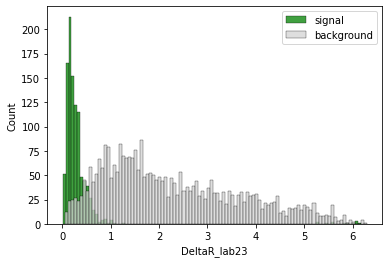

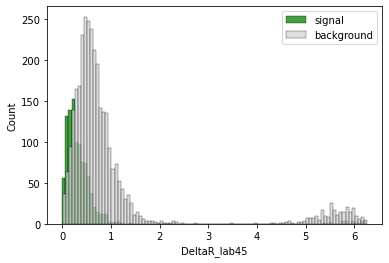

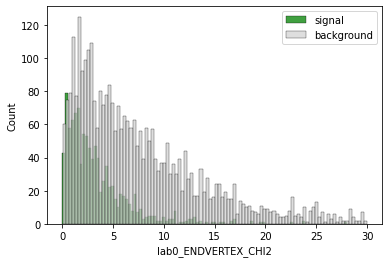

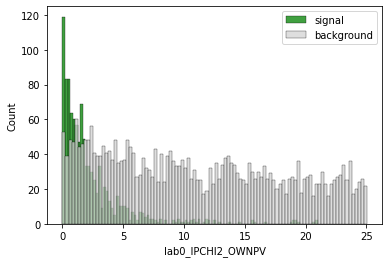

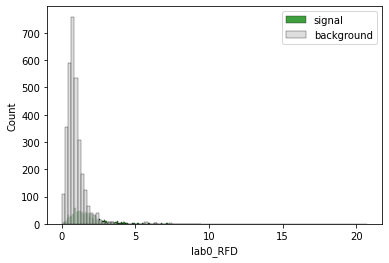

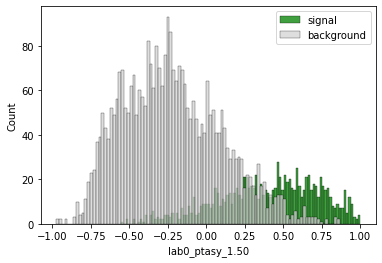

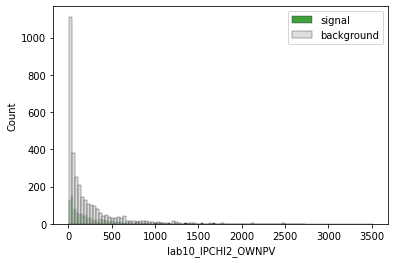

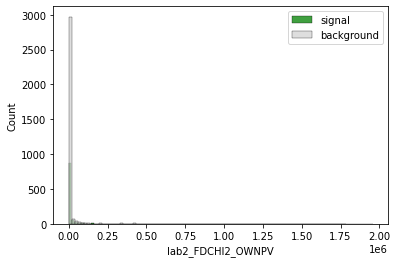

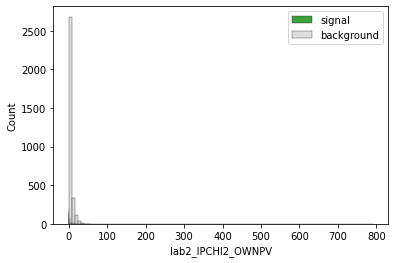

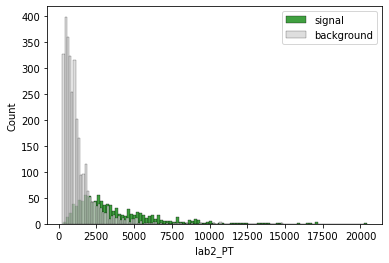

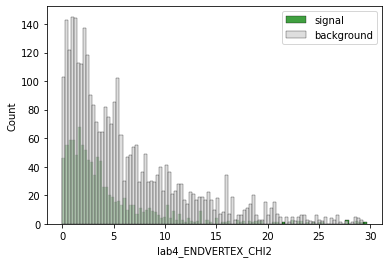

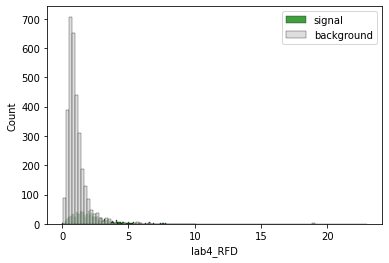

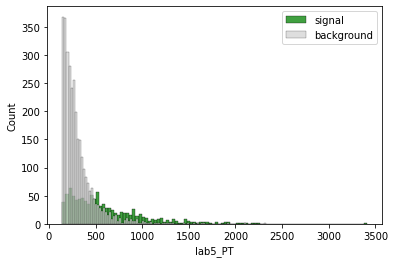

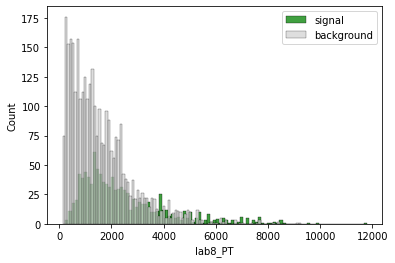

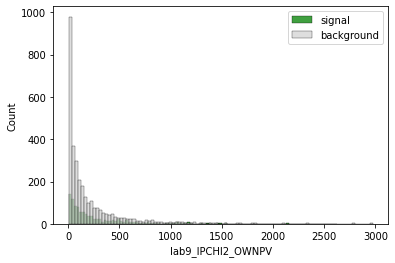

In [9]:
# Plot classification by feature
float_predictions = booster.predict(test_data_matrix).tolist()
predictions = list(map(round, float_predictions))
for feature_name in data_test[feature_names]:
    feature = pd.DataFrame(data_test[feature_name])
    feature.insert(1, "prediction", predictions, True)
    signal = feature[feature["prediction"] == 1]
    background = feature[feature["prediction"] == 0]
    
    plt.figure()
    sns.histplot(signal[feature_name], bins=100, color="green", label="signal")
    sns.histplot(background[feature_name], bins=100, color="lightgray", label="background")
    plt.legend()


In [4]:
# calculate shap values
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X)

In [5]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

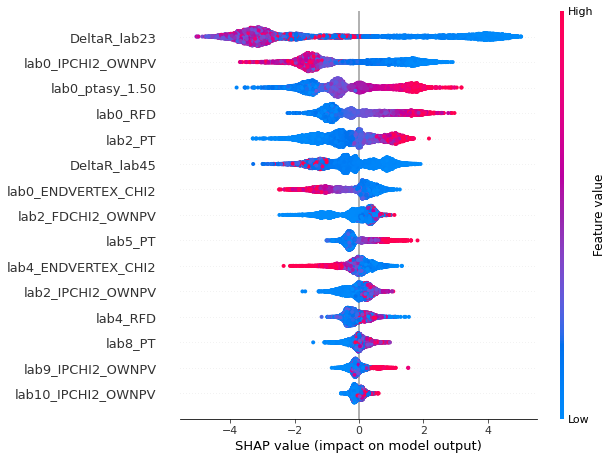

In [6]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)
"""
Wykres sumaryczny uwzgldnia wszystkie cechy uzyte w modelu. Prezentowane ponizej cechy s
"""